# Data Preparation

Dataset: https://www.kaggle.com/datasets/nasa/astronaut-yearbook/data

<a href="https://colab.research.google.com/github/simecek/dspracticum2023/blob/main/lesson08/ds_practicum_ex_astronauts_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

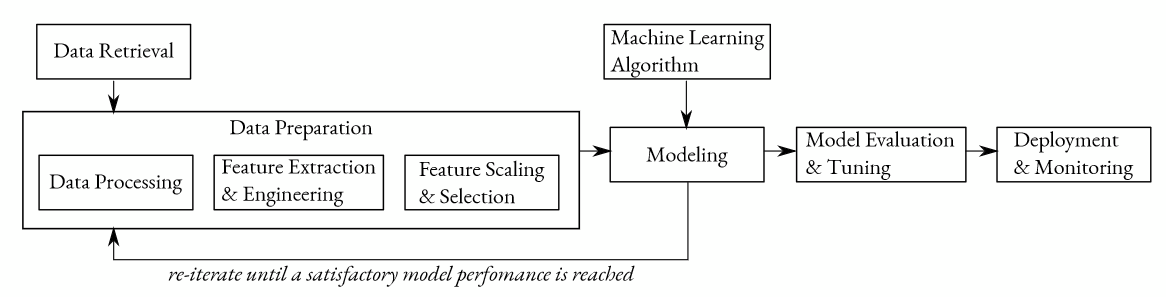

Download the dataset:

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'amllogin'
os.environ['KAGGLE_KEY'] = '35eca611ac64064016cba986e2161cdd'

!kaggle datasets download -d nasa/astronaut-yearbook -p {'.'}

astronaut-yearbook.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

dataset_path = '/content/data_preparation_exercise/'

with zipfile.ZipFile('astronaut-yearbook.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

In [ ]:
import pandas as pd

csv_filepath = dataset_path + 'astronauts.csv'
df = pd.read_csv(csv_filepath)
df

## 0. Data Exploration

- get insights to your dataset (you can laso look at the original dataset description at https://www.kaggle.com/datasets/nasa/astronaut-yearbook/data)


In [ ]:
# TODO: get insight into your dataset, use functions as
# df.describe(), df.info()

# answer the next questions:

What is the Gender ratio?

In [ ]:
import matplotlib.pyplot as plt

# TODO: count distinct values of values in the 'Gender' column and display the result (e.g. as a pie chart)

Plot histogram of values of one feature (1 column):

In [ ]:
import seaborn as sns

# TODO
# hint: use sns.histplot()

Was somebody on more than one `Mission`s?

(hint: Missions would be separated by a comma.)

In [ ]:
# TODO: parse the information in 'Mission' column and count the number of missions, then filter based on that number

How many astronauts died on a mission?

In [ ]:
# TODO

How the total number of `Space Flights` (especially for Males vs Females) have evolved over the years.

In [ ]:
# TODO: plot line charts of 'Space Flights' count throughout the 'Year', colour by 'Gender'

How many astronauts were on a mission in a different century than the one they were born in?

In [ ]:
# TODO: use the 'Year' and 'Birth Date' columns

## 1. Data Cleaning

Look for duplicites:

In [ ]:
df.loc[df.duplicated()]

We can also look for duplicites only w.r.t. to one feature and not the entire sample (row):

In [ ]:
df.loc[df.duplicated(['Birth Date'])]

In [ ]:
# TODO: are there any duplicates we should be concerned about?

Missing data:

In [ ]:
df.info()

We can see that we have sone Null values in columns `Year`, `Group`, `Alma Mater`, `Undergraduate Major`, `Graduate Major`, `Undergraduate Major`, `Graduate Major`, `Military Rank`, `Military Branch`, `Missions`, `Death Date`, and `Death Mission`.



Focus on one feature (`Military Branch`):

In [ ]:
# TODO: check few samples from our dataset with the missing value - how are we going to handle it?

Leave the missing value as it is for these features:

*(here the fact that the value is missing indicates an important sample property)*

In [ ]:
df['Group'].fillna('None', inplace=True)
# TODO: add the rest features where a missing value indicates some sample property
df

Fill in with mean:

In [ ]:
df['Year'].fillna(int(df['Year'].mean(numeric_only=True)), inplace=True)
df

Remove rows with missing value(s):

In [ ]:
df.dropna(subset=['Alma Mater'], how='all', inplace=True)
df

Quick check that our dataset no longer contains any missing values:

In [ ]:
# TODO

## 2. Feature manipulation:

#### Categorical features encoding:

(`object` type from `df.info()`)

In [ ]:
df_transformed = df.copy()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# custom one hot encoder that just directly assigns correct names to columns
class OneHotEncoderWithColNames(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.feature_names = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = pd.get_dummies(X)
        print(result.columns)
        self.feature_names = result.columns
        return result

Example - encoding the `Status` feature:

In [ ]:
df_transformed['Status'].value_counts()

In [ ]:
ohe_status = OneHotEncoderWithColNames(handle_unknown='ignore')
ohe_status_df = pd.DataFrame(ohe_status.fit_transform(df_transformed[['Status']]))
df_transformed = df_transformed.join(ohe_status_df)
df_transformed

`Gender` gets handled the same way:

In [ ]:
# TODO

What about features with more distinct values?

In [ ]:
df_transformed['Graduate Major'].value_counts()

In [ ]:
# TODO: look at other categorical features and come up with a way of encoding their values

Binning of `Graduate Major`s based on simple key words:

In [ ]:
def get_superior_category(major_str):
  if 'engineer' in major_str.lower():
    return 'Engineering'
  elif 'bio' in major_str.lower() or 'science' in major_str.lower() or 'astro' in major_str.lower() or 'physics' in major_str.lower() or 'math' in major_str.lower() or 'inf' in major_str.lower():
    return 'Science'
  elif 'med' in major_str.lower() or 'doctor' in major_str.lower() or 'health' in major_str.lower():
    return 'Medicine'
  elif 'business' in major_str.lower() or 'management' in major_str.lower():
    return 'Business'
  elif 'None' == major_str:
    return 'None'
  return 'Different'

df_transformed['Graduate Major'] = df_transformed.apply(lambda row: get_superior_category(row['Graduate Major']), axis=1)
df_transformed['Graduate Major'].value_counts()

In [ ]:
ohe_grad = OneHotEncoderWithColNames(handle_unknown='ignore')
ohe_grad_df = pd.DataFrame(ohe_grad.fit_transform(df_transformed[['Graduate Major']]))
df_transformed = df_transformed.join(ohe_grad_df)
df_transformed

#### Numerical feature scaling:

In [ ]:
numerical_features = df.select_dtypes(include='number').columns.tolist()
numerical_features

In [ ]:
from sklearn import preprocessing

standard_scaler = preprocessing.StandardScaler(copy=True)
df_transformed.loc[:,numerical_features] = standard_scaler.fit_transform(df_transformed[numerical_features])
df_transformed.loc[:,numerical_features]

In [ ]:
# TODO: normalize these features as well (using MinMaxScaler)

*Data format specifics:*

*Images - data augmentations*

*Text - tokenization*

## 3. Feature Selection

- correlation matrix

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# TODO: drop features that are heavily correlated
# df.drop(['Missions Count'], axis=1, inplace=True)

## 4. Dimensionality reduction

#### PCA:

In [ ]:
# select only numerical features
df_numerical = df_transformed.select_dtypes(include='number')
df_numerical

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(df_numerical)

# join the PCA info with our original df:
components = pd.DataFrame(components)
df_transformed['PCA 0'] = components[0]
df_transformed['PCA 1'] = components[1]

In [ ]:
import plotly.express as px

def show_reduced_dimensions_interactive(color_column, x='PCA 0', y='PCA 1'):
  fig = px.scatter(df_transformed,
                  x=x,
                  y=y,
                  color=color_column,
                  hover_name='Name',
                  hover_data=['Year', 'Group', 'Status', 'Birth Date',
                              'Birth Place', 'Gender', 'Alma Mater',
                              'Undergraduate Major', 'Graduate Major',
                              'Military Rank', 'Military Branch',
                              'Space Flights', 'Space Flight (hr)',
                              'Space Walks', 'Space Walks (hr)', 'Missions',
                              'Death Date', 'Death Mission', 'Missions Count']
                  )
  fig.show()

show_reduced_dimensions_interactive('Gender')

In [ ]:
show_reduced_dimensions_interactive('Status')

#### T-SNE:

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_numerical)
tsne_results = pd.DataFrame(tsne_results)
df_transformed['TSNE 0'] = tsne_results[0]
df_transformed['TSNE 1'] = tsne_results[1]

In [ ]:
show_reduced_dimensions_interactive('Gender', 'TSNE 0', 'TSNE 1')

## 5. Splitting data to train and test sets (dataset sampling):

In [ ]:
# TODO: reason why it is good/ bad idea to model the 'Status' feature

In [ ]:
df['Status'].value_counts()

In [ ]:
X = df_transformed[['PCA 0', 'PCA 1']]
Y = df_transformed['Status']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    train_size=100,
                                                    test_size=0.2)
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classifier_lr = LogisticRegression(random_state=42)
classifier_lr.fit(x_train, y_train)

predicted = classifier_lr.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, predicted)*100:.5} %')

cm = confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [ ]:
# TODO: discuss how we want to handle our class imbalance